# Single-Touch Attribution Models
Single-touch attribution models assign 100% of carrier credit to **one marketing channel**, disregarding any number of channels visited by a user. This is a naïve approach and has a low level of complexity. These models should only be used when there are five or less touch points in a customer's journey, the preferred of which is the Last-Touch Attribution Model.
## Import Dependencies and Load Data

In [24]:
import itertools
from collections import Counter, defaultdict
from itertools import permutations, combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from gekko import GEKKO
from pandas.plotting import scatter_matrix
from pandas_profiling import ProfileReport
from PIL import Image

%matplotlib inline
sns.set_palette('summer')

In [2]:
df = pd.read_csv('data/attribution_data.csv')
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


## Last-Touch Attribution Model
Here, we assign 100% of the carrier credit to the last marketing touchpoint. 
> The argument behind this approach is that the last touch is all that matters because it resulted in the actual conversion, but in reality, it doesn't tell the whole story.

In [15]:
def last_touch_model(df, conv_col, channel_col):
    """
    Get the weight of each channel out of all last clicks (clicks leading to a conversion)
    """
    last_touch = df[df[conv_col] == 1]
    res_last_touch = pd.DataFrame(
        round(last_touch[channel_col].value_counts(normalize=True) * 100, 2),
    )
    res_last_touch.columns = ['Weight (%)']
    return res_last_touch


last_touch = last_touch_model(df, 'conversion', 'channel')
last_touch

,Weight (%)
Facebook,30.05
Paid Search,25.78
Online Video,19.32
Instagram,12.72
Online Display,12.13


Text(0.5, 1.0, 'Last Clicks Channel Weights')

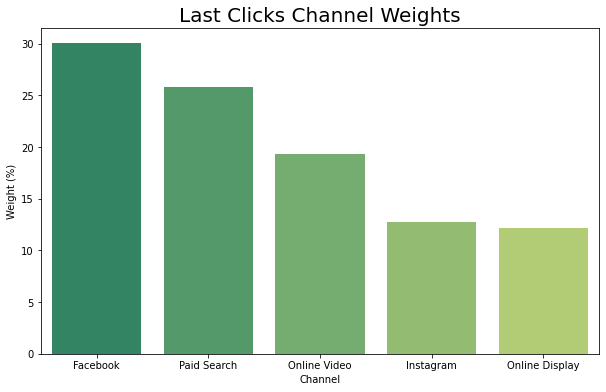

In [29]:
plt.subplots(figsize=(10, 6))
sns.barplot(data=last_touch, x=last_touch.index, y='Weight (%)')
plt.xlabel('Channel')
plt.title('Last Clicks Channel Weights', fontsize=20)

## First-Touch Attribution Model
Here, a customer's first marketing interaction will receive 100% of the coversion credit. 
> If one is mainly focused on widening [the] top of [their] funnel, this is a useful model. It highlights the channels that first introuced a customer to [the] brand.

The problem with this model is that it ignores all subsequent touches, and therefore provides no insight into down-funnel metrics.

In [30]:
def first_touch_model(df, conv_col, channel_col, user_id):
    """
    Get the weight of each channel out of all first clicks by users
    """
    tmp = df[df[conv_col] == 1]
    first_touch = pd.DataFrame(df.groupby(user_id).first(), index=df[user_id])
    cookie_index = list(tmp[user_id])
    mid_first_touch = first_touch.loc[cookie_index]
    res_first_touch = pd.DataFrame(round(
        mid_first_touch[channel_col].value_counts(normalize=True) * 100, 2))
    res_first_touch.columns = ['Weight (%)']
    return res_first_touch


first_touch = first_touch_model(df, 'conversion', 'channel', 'cookie')
first_touch

,Weight (%)
Facebook,32.59
Online Video,25.20
Paid Search,18.47
Instagram,14.78
Online Display,8.95


Text(0.5, 1.0, 'First Clicks Channel Weights')

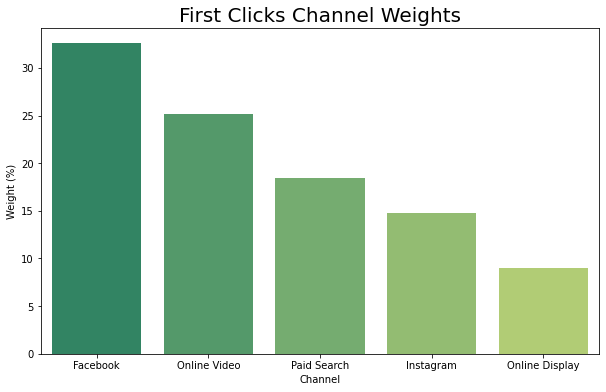

In [31]:
plt.subplots(figsize=(10, 6))
sns.barplot(data=first_touch, x=first_touch.index, y='Weight (%)')
plt.xlabel('Channel')
plt.title('First Clicks Channel Weights', fontsize=20)

Facebook seems to be driving the most revenue for both models, but Online Video and Paid Search seem to have switched in weight amounts between last and first clicks.
## Last Non-Direct Attribution Model
This model ignores direct traffic, and it
> assigns 100% of the credit to the last channel the user engaged with before making a conversion.

This is best used if one wants to understand effectiveness of their final marketing activities without direct traffic getting in the way of their analysis. However, this is still ignoring the other campaigns and channels with which the customer interacted.

In [32]:
def last_non_direct_model(df, conv_col, channel_col, user_id):
    """
    Get the weight of each channel out of all last non-direct interactions by users
    """
    second_last = pd.DataFrame(df.groupby(user_id).tail(2))
    tmp = second_last[second_last[conv_col] == 1]
    last_non_direct = pd.DataFrame(second_last.groupby(user_id).first(), 
                                   index=second_last[user_id])
    cookie_index = list(tmp[user_id])
    mid_last_non_direct = last_non_direct.loc[cookie_index]
    res_last_non_direct = pd.DataFrame(round(
        mid_last_non_direct[channel_col].value_counts(normalize=True) * 100, 2))
    res_last_non_direct.columns = ['Weight (%)']
    return res_last_non_direct
    

last_non_direct = last_non_direct_model(df, 'conversion', 'channel', 'cookie')
last_non_direct

,Weight (%)
Facebook,29.97
Paid Search,24.97
Online Video,20.47
Instagram,13.22
Online Display,11.37


Text(0.5, 1.0, 'Last Non-Direct Interaction Channel Weights')

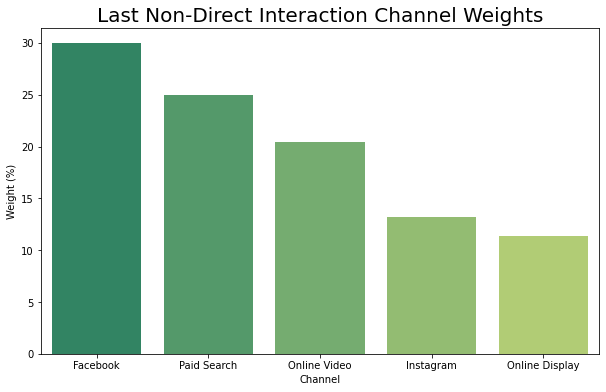

In [33]:
plt.subplots(figsize=(10, 6))
sns.barplot(data=last_non_direct, x=last_non_direct.index, y='Weight (%)')
plt.xlabel('Channel')
plt.title('Last Non-Direct Interaction Channel Weights', fontsize=20)

Facebook is still on top in terms of weight, but Paid Search went back to being the second-most contributing for non-direct attributions.